In [1]:
from spacy.lang.hi import Hindi 
nlp = Hindi()

In [2]:
import requests 
url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.hi.300.vec.gz"
r = requests.get(url, allow_redirects=True)
fpath = url.split("/")[-1]
with open(fpath, "wb") as fw:
  fw.write(r.content)

In [3]:
! python -m spacy init-model hi ./hi_vectors_wiki_lg --vectors-loc cc.hi.300.vec.gz

✔ Successfully created model
⠹ Reading vectors from cc.hi.300.vec.gztcmalloc: large alloc 2251988992 bytes == 0x55a94bf02000 @  0x7f06ce5ff001 0x7f06cc17d54f 0x7f06cc1cdb58 0x7f06cc1d1b17 0x7f06cc270203 0x55a949a910e4 0x55a949a90de0 0x55a949b056f5 0x55a949a9269a 0x55a949b00a45 0x55a949affb0e 0x55a949a9277a 0x55a949b00a45 0x55a949affb0e 0x55a9499d1eb0 0x55a949b021e6 0x55a949affe0d 0x55a949a9277a 0x55a949b00c9e 0x55a949affb0e 0x55a949a9277a 0x55a949b04e50 0x55a949affb0e 0x55a949aff813 0x55a949afdcc0 0x55a949a90ee9 0x55a949a90de0 0x55a949b04ac2 0x55a949affb0e 0x55a949a9277a 0x55a949b00a45
1876653it [02:50, 10992.36it/s]
✔ Loaded vectors from cc.hi.300.vec.gz
✔ Sucessfully compiled vocab
1876653 entries, 1876653 vectors


In [4]:
import spacy
nlp_hi = spacy.load("./hi_vectors_wiki_lg")

In [5]:
import numpy as np

def preprocess_data(with_pos_tag = False):
  total_states = []
  f = open("dataset.txt", "r",encoding = 'utf-8')
  lines = f.readlines()
  line = ""
  for word in lines:
    word = word.split('\t')

    if(len(word) != 1):
      tag = word[1].strip()
      word = word[0].strip()
      
      if(with_pos_tag == False):
        total_states.append(word)
      else:
        total_states.append(word + " " + tag)

  train_size = (len(total_states) * 80)//100

  train_set = total_states[:train_size]
  test_set = total_states[train_size:]

  X_train = []
  for word in range(len(train_set)):
    if(word%20000 == 0):
      print(word)
    doc = nlp_hi(train_set[word])
    current_vector = doc[0].vector
    X_train.append(current_vector)

  X_test = []
  for word in range(len(test_set)):
    if(word%20000 == 0):
      print(word)
    doc = nlp_hi(test_set[word])
    current_vector = doc[0].vector
    X_test.append(current_vector)

  X_train = np.array(X_train)
  X_test = np.array(X_test)
  return train_set, test_set, X_train, X_test

In [6]:
def measure_accuracy(train_set, test_set, Y_train, Y_test, with_pos_tag = True):
  file2 = open('hin-token-chunk-conll-treebank.txt', 'r')
  result_lines = file2.readlines()
  tags = {}

  for line in result_lines:
    word = line.split('\t')
    if(len(word) != 1):
      token = word[0].strip()
      word = word[1].strip()
      if(word[0] == 'B'):
        tags[token] = 0

      else:
        tags[token] = 1

  if(with_pos_tag == True):
    for i in range(len(train_set)):
      train_set[i] = train_set[i].split()[0]

    for i in range(len(test_set)):
      test_set[i] = test_set[i].split()[0]


  total_correct = 0
  for i in range(len(Y_train)):
    if(Y_train[i] == tags[train_set[i]]):
      total_correct += 1

  print("Training Accuracy is : ", max(100 - (total_correct / len(train_set)*100), (total_correct / len(train_set)*100)))
  train_accuracy = max(100 - (total_correct / len(train_set)*100), (total_correct / len(train_set)*100))
  total_correct = 0
  for i in range(len(test_set)):
    if(Y_test[i] == tags[test_set[i]]):
      total_correct += 1

  print("Testing Accuracy is : ", max(100 - (total_correct / len(test_set)*100), (total_correct / len(test_set)*100)))
  test_accuracy = max(100 - (total_correct / len(test_set)*100), (total_correct / len(test_set)*100))
  return train_accuracy, test_accuracy


In [ ]:
train_set, test_set, X_train, X_test = preprocess_data()

0
20000
40000
60000
80000
100000
120000
140000
160000
180000
200000
220000
240000
260000
280000
300000
320000
340000
0
20000
40000
60000
80000


In [ ]:
from sklearn.cluster import KMeans
modelkmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, n_jobs = -1)
modelkmeans.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
Y_train = modelkmeans.predict(X_train)
Y_test = modelkmeans.predict(X_test)

In [ ]:
measure_accuracy(train_set, test_set, Y_train, Y_test)

Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405


(59.078224344774014, 59.12218923335405)

In [ ]:
!pip install hmmlearn

     |████████████████████████████████| 378kB 9.1MB/s 


In [ ]:
from hmmlearn import hmm

model = hmm.GaussianHMM(n_components=2)
model.fit(X_train)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=2, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [ ]:
Y_train = model.predict(X_train)
Y_test = model.predict(X_test)

In [ ]:
measure_accuracy(train_set, test_set, Y_train, Y_test)

Training Accuracy is :  54.21674961880376
Testing Accuracy is :  54.87928375796911


(54.21674961880376, 54.87928375796911)

In [ ]:
import pickle
pickle.dump(modelkmeans, open("model_embedding_without_pos_kmeans.pkl", "wb"))
pickle.dump(model, open("model_embedding_without_pos_hmm.pkl", "wb"))

In [ ]:
from sklearn.decomposition import PCA

train_accuracy = []
test_accuracy = []
for components in range(1, 200):
  trying_vector = X_train.copy()
  pca = PCA(n_components=components)
  pca.fit(trying_vector)
  trying_vector = pca.transform(trying_vector)
  modelkmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, n_jobs = -1)
  modelkmeans.fit(trying_vector)
  train_results = modelkmeans.predict(trying_vector)
  testing_vector = X_test.copy()
  testing_vector = pca.transform(testing_vector)
  test_results = modelkmeans.predict(testing_vector)
  train_acc, test_acc = measure_accuracy(train_set, test_set, train_results, test_results)
  train_accuracy.append(train_acc)
  test_accuracy.append(test_acc)
  if(components % 50 == 0):
    print(components)

Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12103845888282
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.1221892

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.078224344774014
Testing Accuracy is :  59.1221892

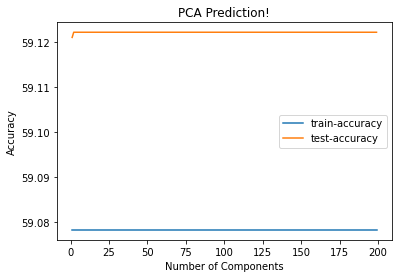

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

x = [i for i in range(1, 200)]
y = train_accuracy
y2 = test_accuracy
plt.plot(x, y, label = "train-accuracy")
plt.plot(x, y2, label = "test-accuracy")

plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('PCA Prediction!')

plt.legend()
plt.show()
plt.savefig('Pretrained_embedding_kmean_without_pos.png')

In [ ]:

train_accuracy = []
test_accuracy = []
for components in range(1, 200):
  trying_vector = X_train.copy()
  pca = PCA(n_components=components)
  pca.fit(trying_vector)
  trying_vector = pca.transform(trying_vector)
  modelkmeans = hmm.GaussianHMM(n_components=2)
  modelkmeans.fit(trying_vector)
  train_results = modelkmeans.predict(trying_vector)
  testing_vector = X_test.copy()
  testing_vector = pca.transform(testing_vector)
  test_results = modelkmeans.predict(testing_vector)
  train_acc, test_acc = measure_accuracy(train_set, test_set, train_results, test_results)
  train_accuracy.append(train_acc)
  test_accuracy.append(test_acc)
  if(components % 50 == 0):
    print(components)

Training Accuracy is :  59.07275813458385
Testing Accuracy is :  59.12103845888282
Training Accuracy is :  59.07448430622285
Testing Accuracy is :  59.12334000782526
Training Accuracy is :  59.07937512586668
Testing Accuracy is :  59.12218923335405
Training Accuracy is :  59.06240110474985
Testing Accuracy is :  59.10953071417063
Training Accuracy is :  58.35639690439886
Testing Accuracy is :  58.23839443945775
Training Accuracy is :  58.35035530366236
Testing Accuracy is :  58.234942116044095
Training Accuracy is :  58.97666791334618
Testing Accuracy is :  58.9208037008907
Training Accuracy is :  58.82936793348485
Testing Accuracy is :  58.767750696218556
Training Accuracy is :  58.275266837365855
Testing Accuracy is :  58.18660958825289
Training Accuracy is :  58.81412008400702
Testing Accuracy is :  58.813781675067325
Training Accuracy is :  59.26004775741534
Testing Accuracy is :  59.24762365071693
Training Accuracy is :  58.868782185908685
Testing Accuracy is :  58.864415751800955

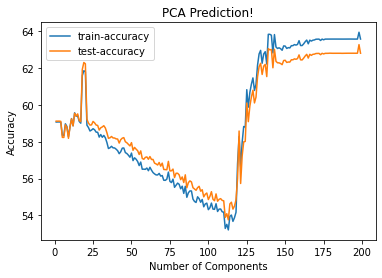

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

x = [i for i in range(1, 200)]
y = train_accuracy
y2 = test_accuracy
plt.plot(x, y, label = "train-accuracy")
plt.plot(x, y2, label = "test-accuracy")

plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('PCA Prediction!')

plt.legend()
plt.show()
plt.savefig('Pretrained_embedding_hmm_without_pos.png')

In [7]:
train_set, test_set, X_train, X_test = preprocess_data(with_pos_tag = True)

0
20000
40000
60000
80000
100000
0
20000


In [ ]:
from sklearn.cluster import KMeans

modelkmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, n_jobs = -1)
modelkmeans.fit(X_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=-1, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
Y_train = modelkmeans.predict(X_train)
Y_test = modelkmeans.predict(X_test)

In [ ]:
measure_accuracy(train_set, test_set, Y_train, Y_test, with_pos_tag = True)

Training Accuracy is :  58.70916666666667
Testing Accuracy is :  58.82666666666667


(58.70916666666667, 58.82666666666667)

In [ ]:
!pip install hmmlearn
from hmmlearn import hmm


     |████████████████████████████████| 378kB 6.4MB/s 


In [ ]:
model = hmm.GaussianHMM(n_components=2)
model.fit(X_train)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=2, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [ ]:
Y_train = model.predict(X_train)
Y_test = model.predict(X_test)

In [ ]:
measure_accuracy(train_set, test_set, Y_train, Y_test)

Training Accuracy is :  53.06916666666667
Testing Accuracy is :  54.809999999999995


(53.06916666666667, 54.809999999999995)

In [ ]:
import pickle
pickle.dump(modelkmeans, open("model_embedding_with_pos_kmeans.pkl", "wb"))
pickle.dump(model, open("model_embedding_with_pos_hmm.pkl", "wb"))

In [9]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

train_accuracy = []
test_accuracy = []
for components in range(1, 200):
  trying_vector = X_train.copy()
  pca = PCA(n_components=components)
  pca.fit(trying_vector)
  trying_vector = pca.transform(trying_vector)
  modelkmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, n_jobs = -1)
  modelkmeans.fit(trying_vector)
  train_results = modelkmeans.predict(trying_vector)
  testing_vector = X_test.copy()
  testing_vector = pca.transform(testing_vector)
  test_results = modelkmeans.predict(testing_vector)
  train_acc, test_acc = measure_accuracy(train_set, test_set, train_results, test_results)
  train_accuracy.append(train_acc)
  test_accuracy.append(test_acc)
  if(components % 50 == 0):
    print(components)

Training Accuracy is :  58.70916666666667
Testing Accuracy is :  58.82666666666667
Training Accuracy is :  58.70916666666667
Testing Accuracy is :  58.82666666666667
Training Accuracy is :  58.70916666666667
Testing Accuracy is :  58.82666666666667
Training Accuracy is :  58.70916666666667
Testing Accuracy is :  58.82666666666667
Training Accuracy is :  58.70916666666667
Testing Accuracy is :  58.82666666666667
Training Accuracy is :  58.70916666666667
Testing Accuracy is :  58.82666666666667
Training Accuracy is :  58.70916666666667
Testing Accuracy is :  58.82666666666667
Training Accuracy is :  58.70916666666667
Testing Accuracy is :  58.82666666666667
Training Accuracy is :  58.70916666666667
Testing Accuracy is :  58.82666666666667
Training Accuracy is :  58.70916666666667
Testing Accuracy is :  58.82666666666667
Training Accuracy is :  58.70916666666667
Testing Accuracy is :  58.82666666666667
Training Accuracy is :  58.70916666666667
Testing Accuracy is :  58.82666666666667
Trai

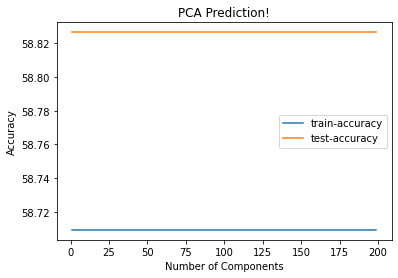

<Figure size 432x288 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt

x = [i for i in range(1, 200)]
y = train_accuracy
y2 = test_accuracy
plt.plot(x, y, label = "train-accuracy")
plt.plot(x, y2, label = "test-accuracy")

plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('PCA Prediction!')

plt.legend()
plt.show()
plt.savefig('Pretrained_embedding_kmean_with_pos.png')

In [ ]:
!pip install hmmlearn
from hmmlearn import hmm

train_accuracy = []
test_accuracy = []
for components in range(1, 200):
  trying_vector = X_train.copy()
  pca = PCA(n_components=components)
  pca.fit(trying_vector)
  trying_vector = pca.transform(trying_vector)
  modelkmeans = hmm.GaussianHMM(n_components=2)
  modelkmeans.fit(trying_vector)
  train_results = modelkmeans.predict(trying_vector)
  testing_vector = X_test.copy()
  testing_vector = pca.transform(testing_vector)
  test_results = modelkmeans.predict(testing_vector)
  train_acc, test_acc = measure_accuracy(train_set, test_set, train_results, test_results)
  train_accuracy.append(train_acc)
  test_accuracy.append(test_acc)
  if(components % 50 == 0):
    print(components)

     |████████████████████████████████| 378kB 16.8MB/s 
Training Accuracy is :  58.696666666666665
Testing Accuracy is :  58.806666666666665
Training Accuracy is :  58.704166666666666
Testing Accuracy is :  58.81666666666667
Training Accuracy is :  58.70583333333334
Testing Accuracy is :  58.82
Training Accuracy is :  58.678333333333335
Testing Accuracy is :  58.776666666666664
Training Accuracy is :  58.67666666666666
Testing Accuracy is :  58.75666666666667
Training Accuracy is :  58.165
Testing Accuracy is :  57.8
Training Accuracy is :  58.57083333333334
Testing Accuracy is :  58.13666666666667
Training Accuracy is :  58.348333333333336
Testing Accuracy is :  57.93333333333334
Training Accuracy is :  58.515
Testing Accuracy is :  58.056666666666665
Training Accuracy is :  58.869166666666665
Testing Accuracy is :  58.39333333333334
Training Accuracy is :  58.71416666666667
Testing Accuracy is :  58.28333333333333
Training Accuracy is :  58.9225
Testing Accuracy is :  58.540000000000

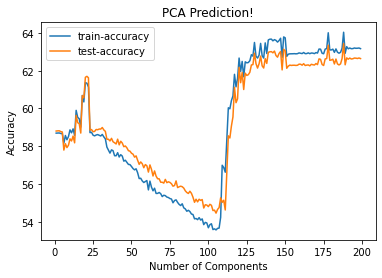

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

x = [i for i in range(1, 200)]
y = train_accuracy
y2 = test_accuracy
plt.plot(x, y, label = "train-accuracy")
plt.plot(x, y2, label = "test-accuracy")

plt.xlabel('Number of Components')
plt.ylabel('Accuracy')
plt.title('PCA Prediction!')

plt.legend()
plt.show()
plt.savefig('Pretrained_embedding_hmm_without_pos.png')